### Created on 2025
### @author: S.W

In [1]:
# 강화학습 입문하기 - 02. 동적 계획법 (Dynamic Programming)
# Chapter 4: 동적 계획법의 원리와 구현

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.unicode_minus'] = False

## 강화학습 입문하기 - 동적 계획법 (Dynamic Programming)
- 동적 계획법의 두 가지 핵심 원리
- 정책 평가 (Policy Evaluation)
- 정책 개선 (Policy Improvement)
- 정책 반복 (Policy Iteration)
- 가치 반복 (Value Iteration)
- 두 방법의 비교와 수렴성 분석

## 동적 계획법 (Dynamic Programming) 기본 개념

동적 계획법이란?
- 복잡한 순차적 의사결정 문제를 체계적으로 해결하는 최적화 기법
- '동적': 시간 흐름에 따라 여러 단계로 분해
- '계획법': 각 단계별로 최적 해를 미리 계획

두 가지 핵심 원리:
1. 중복되는 부분 문제 (Overlapping Subproblems)
   → 같은 계산을 반복하지 않고 결과를 저장해서 재사용
2. 최적 부분 구조 (Optimal Substructure)
   → 전체 최적해를 부분 문제의 최적해로 구성 가능

강화학습에서의 적용:
- 환경 모델(전이 확률, 보상)이 완전히 주어진 상황
- 벨만 방정식을 반복적으로 적용하여 최적 정책 계산
- 모든 상태를 체계적으로 업데이트 (상향식 접근)

In [2]:
# GridWorld 환경 설정 (4x4)

print("GridWorld 환경 설정")

# 환경 매개변수
GRID_SIZE = 4
N_STATES = GRID_SIZE * GRID_SIZE
N_ACTIONS = 4

# 행동 정의: 0=상, 1=하, 2=좌, 3=우
ACTIONS = ['↑', '↓', '←', '→']
ACTION_EFFECTS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

print(f"환경 설정:")
print(f"• 그리드 크기: {GRID_SIZE}x{GRID_SIZE}")
print(f"• 총 상태 수: {N_STATES}")
print(f"• 행동 종류: {ACTIONS}")

GridWorld 환경 설정
환경 설정:
• 그리드 크기: 4x4
• 총 상태 수: 16
• 행동 종류: ['↑', '↓', '←', '→']


In [3]:
# 상태 변환 함수들
def state_to_coord(state):
    """상태 번호를 (행, 열) 좌표로 변환"""
    return (state // GRID_SIZE, state % GRID_SIZE)

def coord_to_state(row, col):
    """(행, 열) 좌표를 상태 번호로 변환"""
    return row * GRID_SIZE + col

def get_next_state(state, action):
    """현재 상태에서 행동을 취했을 때 다음 상태 반환"""
    row, col = state_to_coord(state)
    d_row, d_col = ACTION_EFFECTS[action]
    
    new_row = row + d_row
    new_col = col + d_col
    
    # 경계 확인
    if 0 <= new_row < GRID_SIZE and 0 <= new_col < GRID_SIZE:
        return coord_to_state(new_row, new_col)
    else:
        return state  # 벽에 부딪히면 제자리

# 종료 상태 정의 (좌상단, 우하단)
TERMINAL_STATES = [0, 15]  # (0,0)과 (3,3)
print(f"종료 상태: {TERMINAL_STATES} (좌상단, 우하단)")

종료 상태: [0, 15] (좌상단, 우하단)


In [4]:
# 보상 함수 정의
def get_reward(state, action, next_state):
    """보상 함수: 모든 전이에서 -1 (종료 상태 제외)"""
    if state in TERMINAL_STATES:
        return 0
    return -1

print("보상 구조: 모든 이동에서 -1 (빨리 종료하도록 유도)")

# 환경 시각화 함수
def visualize_grid(values, title="GridWorld", value_type="value"):
    """그리드 환경 시각화"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 값들을 그리드 형태로 변환
    if len(values.shape) == 1:
        grid_values = values.reshape(GRID_SIZE, GRID_SIZE)
    else:
        grid_values = values
    
    # 히트맵 생성
    im = ax.imshow(grid_values, cmap='RdYlBu_r', aspect='equal')
    
    # 각 셀에 값 표시
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            state = coord_to_state(i, j)
            if value_type == "value":
                text = f"{grid_values[i, j]:.1f}"
            else:
                text = str(grid_values[i, j])
            
            # 종료 상태 표시
            if state in TERMINAL_STATES:
                ax.add_patch(Rectangle((j-0.4, i-0.4), 0.8, 0.8, 
                                     fill=False, edgecolor='red', linewidth=3))
                text += "\n(T)"
            
            ax.text(j, i, text, ha='center', va='center', 
                   fontsize=12, fontweight='bold')
    
    # 격자 선 추가
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', size=0)
    
    # 축 라벨 설정 (영어 + 한글 주석)
    ax.set_xticks(range(GRID_SIZE))
    ax.set_yticks(range(GRID_SIZE))
    ax.set_xlabel('Column')  # 열
    ax.set_ylabel('Row')  # 행
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # 컬러바 추가
    plt.colorbar(im, ax=ax, shrink=0.8)
    plt.show()

보상 구조: 모든 이동에서 -1 (빨리 종료하도록 유도)


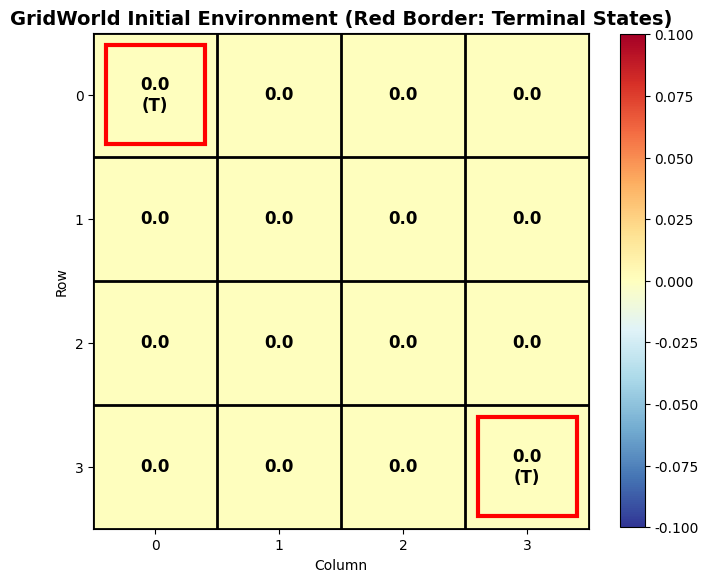

In [5]:
# 초기 환경 시각화
initial_values = np.zeros(N_STATES)
visualize_grid(initial_values, "GridWorld Initial Environment (Red Border: Terminal States)")  # GridWorld 초기 환경 (빨간 테두리: 종료 상태)

### 정책 평가 (Policy Evaluation)
정책 평가란?<br>
- 고정된 정책 π 하에서 각 상태의 가치 함수 V_π(s) 계산<br>
- 벨만 기대 방정식을 반복적으로 적용<br>
- '현재 정책을 따를 때 각 상태가 얼마나 좋은가?' 평가<br>

In [6]:
# 균등 정책 정의 (모든 행동을 동일 확률로 선택)
def create_uniform_policy():
    """균등 정책 생성: 모든 상태에서 모든 행동을 25% 확률로 선택"""
    policy = np.ones((N_STATES, N_ACTIONS)) / N_ACTIONS
    # 종료 상태에서는 행동하지 않음
    for terminal_state in TERMINAL_STATES:
        policy[terminal_state] = 0
    return policy

uniform_policy = create_uniform_policy()

print("\n균등 정책 사용:")
print("• 모든 상태에서 4방향을 25% 확률로 선택")
print("• 종료 상태에서는 행동하지 않음")
uniform_policy


균등 정책 사용:
• 모든 상태에서 4방향을 25% 확률로 선택
• 종료 상태에서는 행동하지 않음


array([[0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 0.  ]])


정책 평가 시작 (할인율: 1.0, 수렴기준: 1e-06)
----------------------------------------
반복  1: 최대 변화량 = 1.898438
반복  2: 최대 변화량 = 1.724609
반복  3: 최대 변화량 = 1.472412
반복  4: 최대 변화량 = 1.406174
반복  5: 최대 변화량 = 1.331708
반복 10: 최대 변화량 = 0.892406
반복 20: 최대 변화량 = 0.372594
반복 30: 최대 변화량 = 0.155274
반복 40: 최대 변화량 = 0.064708
반복 50: 최대 변화량 = 0.026966
반복 60: 최대 변화량 = 0.011238
반복 70: 최대 변화량 = 0.004683
반복 80: 최대 변화량 = 0.001952
반복 90: 최대 변화량 = 0.000813
반복 100: 최대 변화량 = 0.000339
반복 110: 최대 변화량 = 0.000141
반복 120: 최대 변화량 = 0.000059
반복 130: 최대 변화량 = 0.000025
반복 140: 최대 변화량 = 0.000010
반복 150: 최대 변화량 = 0.000004
반복 160: 최대 변화량 = 0.000002
수렴 완료! (총 167회 반복)

균등 정책의 상태 가치 함수:
상태 (0,0):   0.00
상태 (0,1): -14.00
상태 (0,2): -20.00
상태 (0,3): -22.00
상태 (1,0): -14.00
상태 (1,1): -18.00
상태 (1,2): -20.00
상태 (1,3): -20.00
상태 (2,0): -20.00
상태 (2,1): -20.00
상태 (2,2): -18.00
상태 (2,3): -14.00
상태 (3,0): -22.00
상태 (3,1): -20.00
상태 (3,2): -14.00
상태 (3,3):   0.00


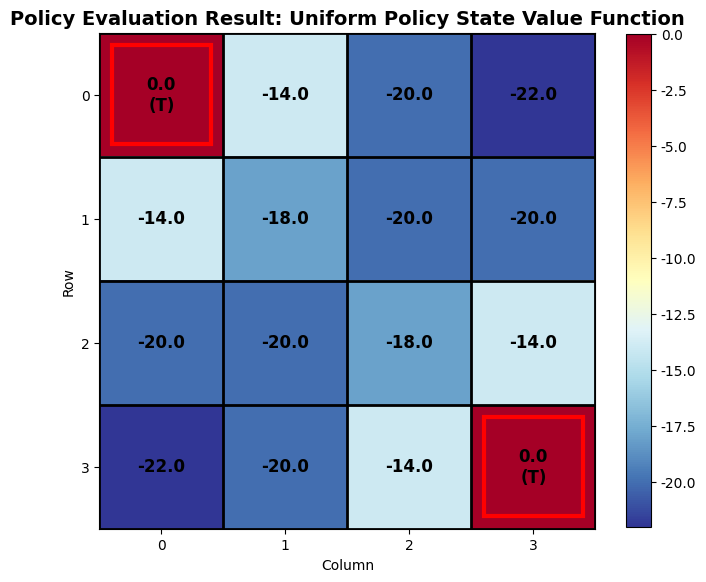

In [7]:
# 정책 평가 구현
def policy_evaluation(policy, gamma=1.0, theta=1e-6):
    """
    정책 평가 알고리즘
    
    Args:
        policy: 평가할 정책 (N_STATES x N_ACTIONS)
        gamma: 할인율
        theta: 수렴 기준 (변화량이 이보다 작으면 종료)
    
    Returns:
        V: 상태 가치 함수
        history: 각 반복에서의 가치 함수 변화 기록
    """
    # 1. 초기화: 모든 상태의 가치를 0으로 설정
    V = np.zeros(N_STATES)
    history = [V.copy()]
    
    iteration = 0
    print(f"\n정책 평가 시작 (할인율: {gamma}, 수렴기준: {theta})")
    print("-" * 40)
    
    while True:
        iteration += 1
        delta = 0  # 최대 변화량 추적
        
        # 2. 모든 상태에 대해 가치 함수 업데이트
        for state in range(N_STATES):
            # 종료 상태는 가치가 0으로 고정
            if state in TERMINAL_STATES:
                continue
                
            # 현재 상태의 이전 가치 저장
            old_value = V[state]
            
            # 벨만 기대 방정식 적용
            new_value = 0
            for action in range(N_ACTIONS):
                # 정책에서 이 행동을 선택할 확률
                action_prob = policy[state, action]
                
                # 다음 상태와 보상 계산
                next_state = get_next_state(state, action)
                reward = get_reward(state, action, next_state)
                
                # 벨만 방정식: π(a|s) * [R + γ * V(s')]
                new_value += action_prob * (reward + gamma * V[next_state])
            
            # 가치 업데이트
            V[state] = new_value
            
            # 변화량 추적
            delta = max(delta, abs(old_value - new_value))
        
        # 기록 저장
        history.append(V.copy())
        
        # 진행 상황 출력 (처음 5번과 매 10번째)
        if iteration <= 5 or iteration % 10 == 0:
            print(f"반복 {iteration:2d}: 최대 변화량 = {delta:.6f}")
        
        # 3. 수렴 확인
        if delta < theta:
            print(f"수렴 완료! (총 {iteration}회 반복)")
            break
    
    return V, history

# 정책 평가 실행
V_uniform, history = policy_evaluation(uniform_policy, gamma=1.0, theta=1e-6)

print(f"\n균등 정책의 상태 가치 함수:")
for i in range(N_STATES):
    row, col = state_to_coord(i)
    print(f"상태 ({row},{col}): {V_uniform[i]:6.2f}")

# 결과 시각화
visualize_grid(V_uniform, "Policy Evaluation Result: Uniform Policy State Value Function")  # 정책 평가 결과: 균등 정책의 상태 가치 함수

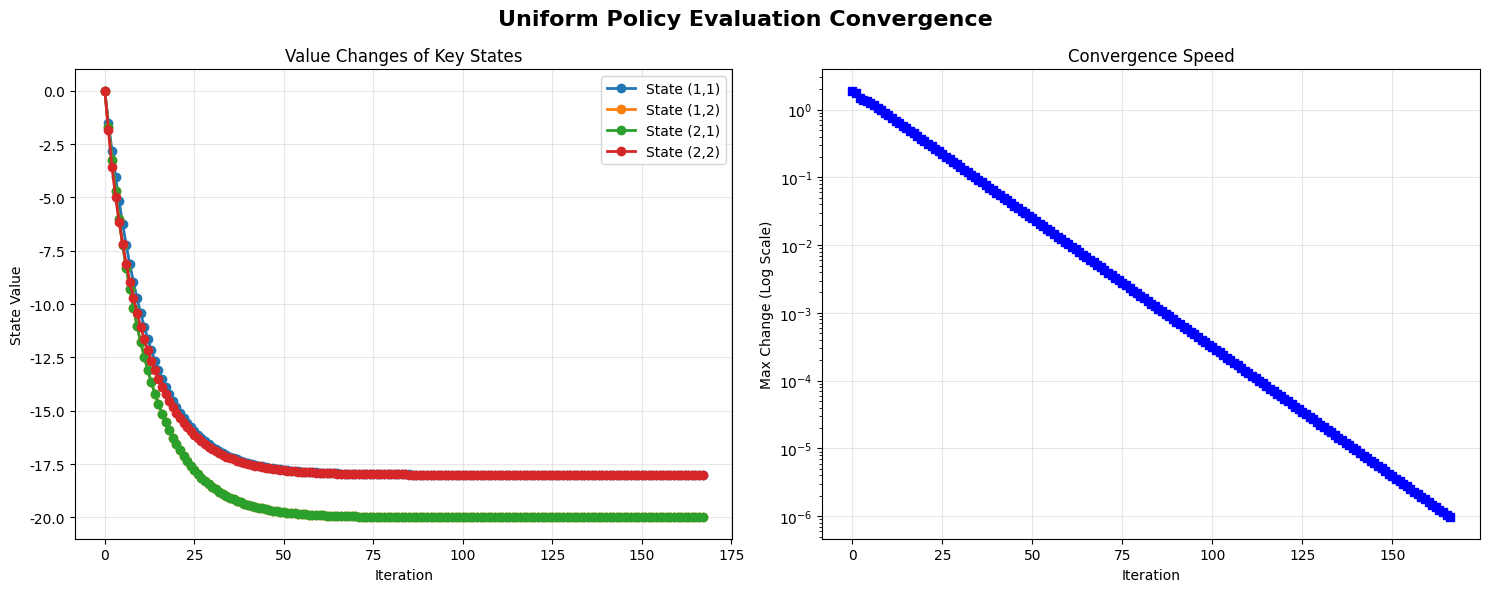

In [8]:
# 수렴 과정 시각화
def plot_convergence(history, title="Policy Evaluation Convergence"):  # 정책 평가 수렴 과정
    """정책 평가의 수렴 과정 시각화"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 왼쪽: 주요 상태들의 가치 변화
    states_to_plot = [5, 6, 9, 10]  # 중앙 부근 상태들
    for state in states_to_plot:
        values = [h[state] for h in history]
        row, col = state_to_coord(state)
        ax1.plot(values, label=f'State ({row},{col})', linewidth=2, marker='o')  # 상태 ({row},{col})
    
    ax1.set_xlabel('Iteration')  # 반복 횟수
    ax1.set_ylabel('State Value')  # 상태 가치
    ax1.set_title('Value Changes of Key States')  # 주요 상태들의 가치 변화
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 오른쪽: 전체 변화량
    max_changes = []
    for i in range(1, len(history)):
        max_change = np.max(np.abs(history[i] - history[i-1]))
        max_changes.append(max_change)
    
    ax2.semilogy(max_changes, 'b-', linewidth=2, marker='s')
    ax2.set_xlabel('Iteration')  # 반복 횟수
    ax2.set_ylabel('Max Change (Log Scale)')  # 최대 변화량 (로그 스케일)
    ax2.set_title('Convergence Speed')  # 수렴 속도
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_convergence(history, "Uniform Policy Evaluation Convergence")  # 균등 정책 평가의 수렴 과정

## 정책 개선 (Policy Improvement)

정책 개선이란<br>
- 정책 평가 결과를 바탕으로 더 나은 정책을 만드는 과정<br>
- 각 상태에서 Q값이 최대인 행동을 선택하는 그리디 정책 생성<br>
- 새로운 정책은 기존 정책보다 같거나 더 좋은 성능 보장<br>

In [9]:
def policy_improvement(V, gamma=1.0):
    """
    정책 개선 알고리즘
    
    Args:
        V: 현재 정책의 상태 가치 함수
        gamma: 할인율
    
    Returns:
        new_policy: 개선된 정책
        Q: 행동 가치 함수 (디버깅용)
        policy_stable: 정책이 변하지 않았는지 여부
    """
    # 행동 가치 함수 계산
    Q = np.zeros((N_STATES, N_ACTIONS))
    
    print("\n1단계: 행동 가치 함수 Q(s,a) 계산")
    print("-" * 30)
    
    for state in range(N_STATES):
        if state in TERMINAL_STATES:
            continue
            
        for action in range(N_ACTIONS):
            next_state = get_next_state(state, action)
            reward = get_reward(state, action, next_state)
            
            # Q(s,a) = R(s,a) + γ * V(s')
            Q[state, action] = reward + gamma * V[next_state]
    
    # 몇 가지 상태의 Q값 출력
    example_states = [5, 6, 9, 10]
    for state in example_states:
        if state not in TERMINAL_STATES:
            row, col = state_to_coord(state)
            print(f"상태 ({row},{col}): Q값 = {Q[state]}")
    
    print("\n2단계: 그리디 정책 생성")
    print("-" * 20)
    
    # 새로운 정책 생성 (그리디)
    new_policy = np.zeros((N_STATES, N_ACTIONS))
    
    for state in range(N_STATES):
        if state in TERMINAL_STATES:
            continue
            
        # 최대 Q값을 가진 행동 찾기
        best_action = np.argmax(Q[state])
        new_policy[state, best_action] = 1.0
        
        row, col = state_to_coord(state)
        print(f"상태 ({row},{col}): 최적 행동 = {ACTIONS[best_action]} (Q={Q[state, best_action]:.2f})")
    
    return new_policy, Q

# 정책 개선 실행
improved_policy, Q_values = policy_improvement(V_uniform, gamma=1.0)


1단계: 행동 가치 함수 Q(s,a) 계산
------------------------------
상태 (1,1): Q값 = [-14.99999335 -20.99999114 -14.99999335 -20.99999114]
상태 (1,2): Q값 = [-20.99999044 -18.99999253 -18.99999184 -20.99999125]
상태 (2,1): Q값 = [-18.99999184 -20.99999125 -20.99999044 -18.99999253]
상태 (2,2): Q값 = [-20.99999114 -14.99999442 -20.99999114 -14.99999442]

2단계: 그리디 정책 생성
--------------------
상태 (0,1): 최적 행동 = ← (Q=-1.00)
상태 (0,2): 최적 행동 = ← (Q=-15.00)
상태 (0,3): 최적 행동 = ← (Q=-21.00)
상태 (1,0): 최적 행동 = ↑ (Q=-1.00)
상태 (1,1): 최적 행동 = ↑ (Q=-15.00)
상태 (1,2): 최적 행동 = ← (Q=-19.00)
상태 (1,3): 최적 행동 = ↓ (Q=-15.00)
상태 (2,0): 최적 행동 = ↑ (Q=-15.00)
상태 (2,1): 최적 행동 = ↑ (Q=-19.00)
상태 (2,2): 최적 행동 = ↓ (Q=-15.00)
상태 (2,3): 최적 행동 = ↓ (Q=-1.00)
상태 (3,0): 최적 행동 = ↑ (Q=-21.00)
상태 (3,1): 최적 행동 = → (Q=-15.00)
상태 (3,2): 최적 행동 = → (Q=-1.00)


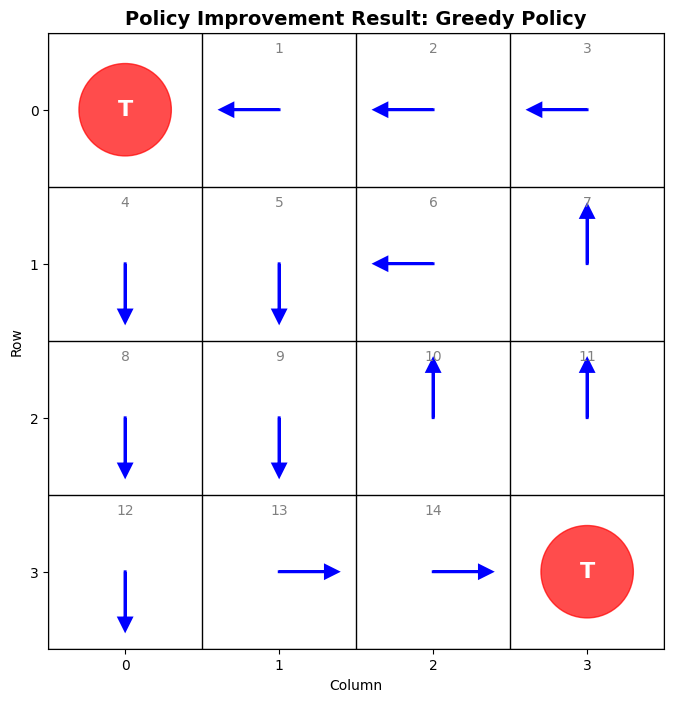

In [10]:
# 개선된 정책 시각화
def visualize_policy(policy, title="Policy Visualization"):  # 정책 시각화
    """정책을 화살표로 시각화"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 배경 그리드
    ax.set_xlim(-0.5, GRID_SIZE - 0.5)
    ax.set_ylim(-0.5, GRID_SIZE - 0.5)
    ax.set_aspect('equal')
    
    # 격자 그리기
    for i in range(GRID_SIZE + 1):
        ax.axhline(i - 0.5, color='black', linewidth=1)
        ax.axvline(i - 0.5, color='black', linewidth=1)
    
    # 각 상태에서의 최적 행동 표시
    for state in range(N_STATES):
        row, col = state_to_coord(state)
        
        if state in TERMINAL_STATES:
            # 종료 상태는 빨간 원으로 표시
            circle = plt.Circle((col, row), 0.3, color='red', alpha=0.7)
            ax.add_patch(circle)
            ax.text(col, row, 'T', ha='center', va='center', 
                   fontsize=16, fontweight='bold', color='white')
        else:
            # 최적 행동을 화살표로 표시
            best_action = np.argmax(policy[state])
            arrow_props = {
                0: (0, 0.3),    # 상 ↑
                1: (0, -0.3),   # 하 ↓  
                2: (-0.3, 0),   # 좌 ←
                3: (0.3, 0)     # 우 →
            }
            
            dx, dy = arrow_props[best_action]
            ax.arrow(col, row, dx, dy, head_width=0.08, head_length=0.08,
                    fc='blue', ec='blue', linewidth=2)
            
            # 상태 번호 표시
            ax.text(col, row - 0.4, f'{state}', ha='center', va='center',
                   fontsize=10, color='gray')
    
    ax.set_xticks(range(GRID_SIZE))
    ax.set_yticks(range(GRID_SIZE))
    ax.set_xlabel('Column')  # 열
    ax.set_ylabel('Row')  # 행
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.invert_yaxis()  # y축 뒤집기
    
    plt.show()

visualize_policy(improved_policy, "Policy Improvement Result: Greedy Policy")  # 정책 개선 결과: 그리디 정책

## 정책 반복 (Policy Iteration)
정책 반복이란?<br>
- 정책 평가와 정책 개선을 번갈아 반복
- 정책이 더 이상 변하지 않을 때까지 계속
- 최적 정책과 최적 가치 함수에 수렴 보장

In [11]:
def policy_iteration(gamma=1.0, theta=1e-6):
    """
    정책 반복 알고리즘
    
    Args:
        gamma: 할인율
        theta: 정책 평가 수렴 기준
    
    Returns:
        policy: 최적 정책
        V: 최적 상태 가치 함수
        history: 각 반복에서의 기록
    """
    # 1. 초기 정책 (균등 정책)
    policy = create_uniform_policy()
    history = {'policies': [], 'values': [], 'iterations': []}
    
    print(f"\n정책 반복 시작 (할인율: {gamma})")
    print("=" * 40)
    
    iteration = 0
    while True:
        iteration += 1
        print(f"\n--- 정책 반복 {iteration}번째 ---")
        
        # 2. 정책 평가
        print("단계 1: 정책 평가 실행...")
        V, eval_history = policy_evaluation(policy, gamma, theta)
        
        # 3. 정책 개선
        print("단계 2: 정책 개선 실행...")
        new_policy, Q = policy_improvement(V, gamma)
        
        # 4. 정책 변화 확인
        policy_stable = np.array_equal(policy, new_policy)
        
        # 기록 저장
        history['policies'].append(policy.copy())
        history['values'].append(V.copy())
        history['iterations'].append(iteration)
        
        if policy_stable:
            print(f"\n정책이 안정화됨! 최적 정책 발견 (총 {iteration}회 반복)")
            break
        else:
            print("정책이 변경됨. 다음 반복 계속...")
            policy = new_policy.copy()
    
    return policy, V, history

# 정책 반복 실행
optimal_policy, optimal_V, pi_history = policy_iteration(gamma=1.0, theta=1e-6)


정책 반복 시작 (할인율: 1.0)

--- 정책 반복 1번째 ---
단계 1: 정책 평가 실행...

정책 평가 시작 (할인율: 1.0, 수렴기준: 1e-06)
----------------------------------------
반복  1: 최대 변화량 = 1.898438
반복  2: 최대 변화량 = 1.724609
반복  3: 최대 변화량 = 1.472412
반복  4: 최대 변화량 = 1.406174
반복  5: 최대 변화량 = 1.331708
반복 10: 최대 변화량 = 0.892406
반복 20: 최대 변화량 = 0.372594
반복 30: 최대 변화량 = 0.155274
반복 40: 최대 변화량 = 0.064708
반복 50: 최대 변화량 = 0.026966
반복 60: 최대 변화량 = 0.011238
반복 70: 최대 변화량 = 0.004683
반복 80: 최대 변화량 = 0.001952
반복 90: 최대 변화량 = 0.000813
반복 100: 최대 변화량 = 0.000339
반복 110: 최대 변화량 = 0.000141
반복 120: 최대 변화량 = 0.000059
반복 130: 최대 변화량 = 0.000025
반복 140: 최대 변화량 = 0.000010
반복 150: 최대 변화량 = 0.000004
반복 160: 최대 변화량 = 0.000002
수렴 완료! (총 167회 반복)
단계 2: 정책 개선 실행...

1단계: 행동 가치 함수 Q(s,a) 계산
------------------------------
상태 (1,1): Q값 = [-14.99999335 -20.99999114 -14.99999335 -20.99999114]
상태 (1,2): Q값 = [-20.99999044 -18.99999253 -18.99999184 -20.99999125]
상태 (2,1): Q값 = [-18.99999184 -20.99999125 -20.99999044 -18.99999253]
상태 (2,2): Q값 = [-20.99999114 -14.99


최적 상태 가치 함수:
상태 (0,0):   0.00
상태 (0,1):  -1.00
상태 (0,2):  -2.00
상태 (0,3):  -3.00
상태 (1,0):  -1.00
상태 (1,1):  -2.00
상태 (1,2):  -3.00
상태 (1,3):  -2.00
상태 (2,0):  -2.00
상태 (2,1):  -3.00
상태 (2,2):  -2.00
상태 (2,3):  -1.00
상태 (3,0):  -3.00
상태 (3,1):  -2.00
상태 (3,2):  -1.00
상태 (3,3):   0.00


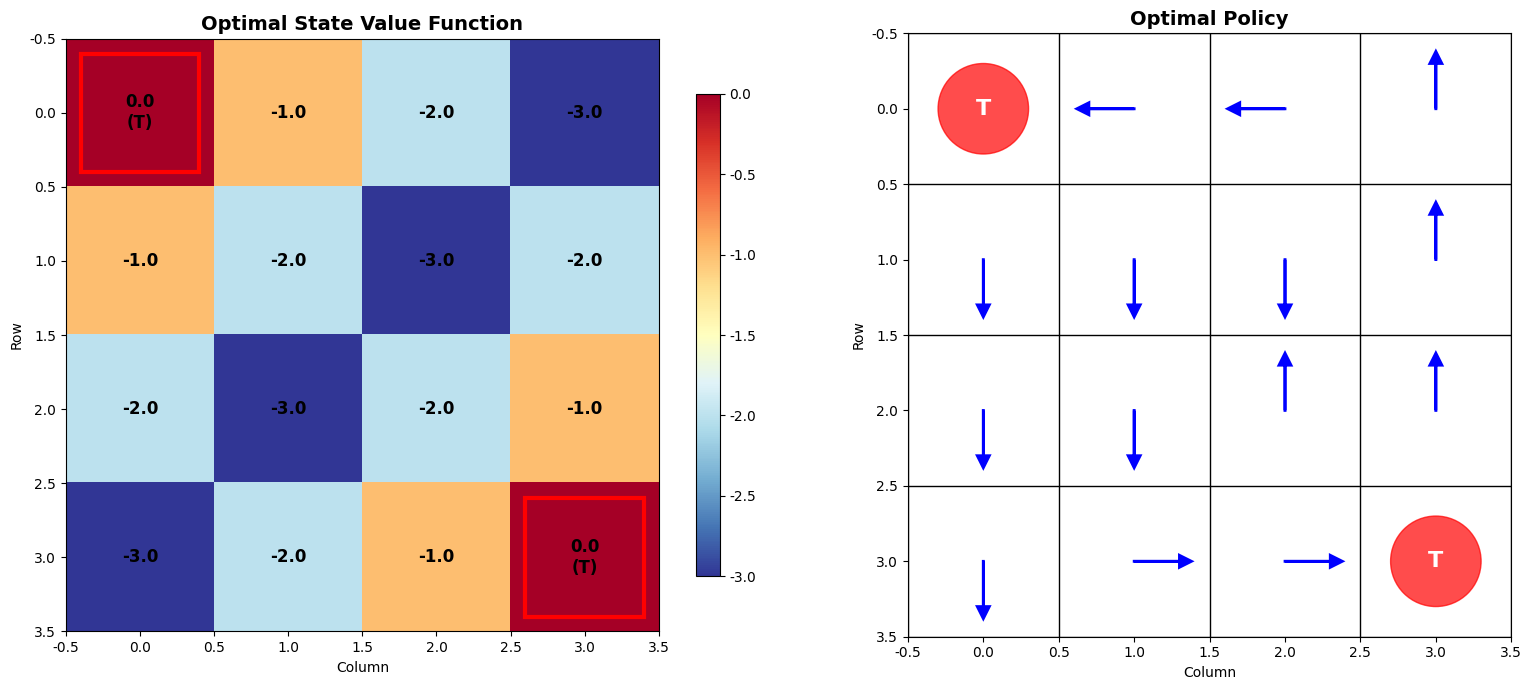

In [12]:
print(f"\n최적 상태 가치 함수:")
for i in range(N_STATES):
    row, col = state_to_coord(i)
    print(f"상태 ({row},{col}): {optimal_V[i]:6.2f}")

# 최적 정책과 가치 함수 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 최적 가치 함수
grid_values = optimal_V.reshape(GRID_SIZE, GRID_SIZE)
im1 = ax1.imshow(grid_values, cmap='RdYlBu_r', aspect='equal')

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        state = coord_to_state(i, j)
        text = f"{grid_values[i, j]:.1f}"
        
        if state in TERMINAL_STATES:
            ax1.add_patch(Rectangle((j-0.4, i-0.4), 0.8, 0.8, 
                                  fill=False, edgecolor='red', linewidth=3))
            text += "\n(T)"
        
        ax1.text(j, i, text, ha='center', va='center', 
               fontsize=12, fontweight='bold')

ax1.set_title('Optimal State Value Function', fontsize=14, fontweight='bold')  # 최적 상태 가치 함수
ax1.set_xlabel('Column')  # 열
ax1.set_ylabel('Row')  # 행
plt.colorbar(im1, ax=ax1, shrink=0.8)

# 최적 정책
ax2.set_xlim(-0.5, GRID_SIZE - 0.5)
ax2.set_ylim(-0.5, GRID_SIZE - 0.5)
ax2.set_aspect('equal')

for i in range(GRID_SIZE + 1):
    ax2.axhline(i - 0.5, color='black', linewidth=1)
    ax2.axvline(i - 0.5, color='black', linewidth=1)

for state in range(N_STATES):
    row, col = state_to_coord(state)
    
    if state in TERMINAL_STATES:
        circle = plt.Circle((col, row), 0.3, color='red', alpha=0.7)
        ax2.add_patch(circle)
        ax2.text(col, row, 'T', ha='center', va='center', 
               fontsize=16, fontweight='bold', color='white')
    else:
        best_action = np.argmax(optimal_policy[state])
        arrow_props = {
            0: (0, 0.3),    # 상 ↑
            1: (0, -0.3),   # 하 ↓  
            2: (-0.3, 0),   # 좌 ←
            3: (0.3, 0)     # 우 →
        }
        
        dx, dy = arrow_props[best_action]
        ax2.arrow(col, row, dx, dy, head_width=0.08, head_length=0.08,
                fc='blue', ec='blue', linewidth=2)

ax2.set_title('Optimal Policy', fontsize=14, fontweight='bold')  # 최적 정책
ax2.set_xlabel('Column')  # 열
ax2.set_ylabel('Row')  # 행
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 가치 반복 (Value Iteration)
가치 반복이란?
- 벨만 최적 방정식을 직접 반복적으로 적용
- 정책 평가와 정책 개선을 한 번에 수행
- 더 간단하고 효율적인 방법


가치 반복 시작 (할인율: 1.0, 수렴기준: 1e-06)
----------------------------------------
반복  1: 최대 변화량 = 1.000000
반복  2: 최대 변화량 = 1.000000
반복  3: 최대 변화량 = 1.000000
반복  4: 최대 변화량 = 0.000000
수렴 완료! (총 4회 반복)

가치 반복으로 구한 최적 상태 가치 함수:
상태 (0,0):   0.00
상태 (0,1):  -1.00
상태 (0,2):  -2.00
상태 (0,3):  -3.00
상태 (1,0):  -1.00
상태 (1,1):  -2.00
상태 (1,2):  -3.00
상태 (1,3):  -2.00
상태 (2,0):  -2.00
상태 (2,1):  -3.00
상태 (2,2):  -2.00
상태 (2,3):  -1.00
상태 (3,0):  -3.00
상태 (3,1):  -2.00
상태 (3,2):  -1.00
상태 (3,3):   0.00


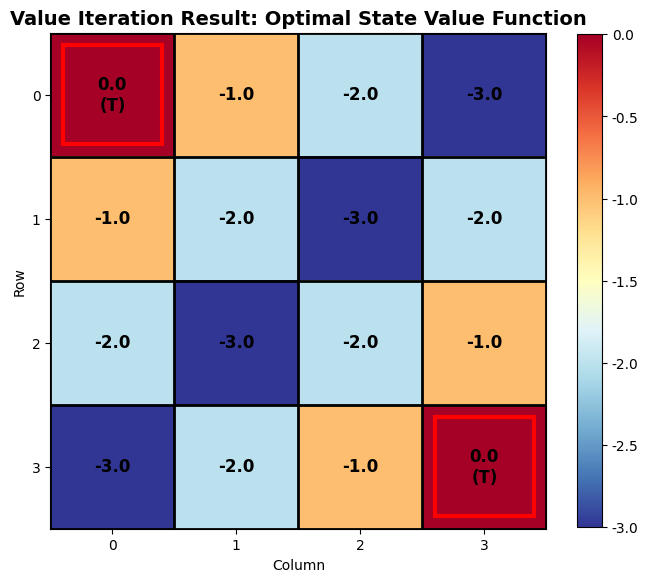

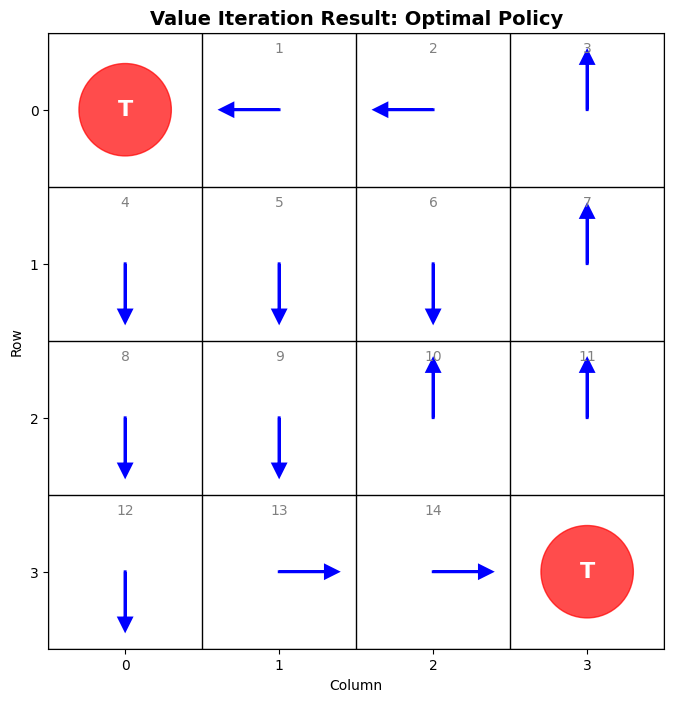

In [13]:
def value_iteration(gamma=1.0, theta=1e-6):
    """
    가치 반복 알고리즘
    
    Args:
        gamma: 할인율  
        theta: 수렴 기준
    
    Returns:
        V: 최적 상태 가치 함수
        policy: 최적 정책
        history: 반복 과정 기록
    """
    # 1. 초기화
    V = np.zeros(N_STATES)
    history = [V.copy()]
    
    print(f"\n가치 반복 시작 (할인율: {gamma}, 수렴기준: {theta})")
    print("-" * 40)
    
    iteration = 0
    while True:
        iteration += 1
        delta = 0
        
        # 2. 모든 상태에 대해 가치 업데이트
        for state in range(N_STATES):
            if state in TERMINAL_STATES:
                continue
                
            old_value = V[state]
            
            # 벨만 최적 방정식: V(s) = max_a Σ_s' P(s'|s,a)[R + γV(s')]
            action_values = []
            for action in range(N_ACTIONS):
                next_state = get_next_state(state, action)
                reward = get_reward(state, action, next_state)
                action_value = reward + gamma * V[next_state]
                action_values.append(action_value)
            
            # 최대값으로 업데이트
            V[state] = max(action_values)
            delta = max(delta, abs(old_value - V[state]))
        
        # 기록 저장
        history.append(V.copy())
        
        # 진행 상황 출력
        if iteration <= 5 or iteration % 10 == 0:
            print(f"반복 {iteration:2d}: 최대 변화량 = {delta:.6f}")
        
        # 3. 수렴 확인
        if delta < theta:
            print(f"수렴 완료! (총 {iteration}회 반복)")
            break
    
    # 4. 최적 정책 추출
    policy = np.zeros((N_STATES, N_ACTIONS))
    for state in range(N_STATES):
        if state in TERMINAL_STATES:
            continue
            
        action_values = []
        for action in range(N_ACTIONS):
            next_state = get_next_state(state, action)
            reward = get_reward(state, action, next_state)
            action_value = reward + gamma * V[next_state]
            action_values.append(action_value)
        
        best_action = np.argmax(action_values)
        policy[state, best_action] = 1.0
    
    return V, policy, history

# 가치 반복 실행
vi_V, vi_policy, vi_history = value_iteration(gamma=1.0, theta=1e-6)

print(f"\n가치 반복으로 구한 최적 상태 가치 함수:")
for i in range(N_STATES):
    row, col = state_to_coord(i)
    print(f"상태 ({row},{col}): {vi_V[i]:6.2f}")

# 가치 반복 결과 시각화
visualize_grid(vi_V, "Value Iteration Result: Optimal State Value Function")  # 가치 반복 결과: 최적 상태 가치 함수
visualize_policy(vi_policy, "Value Iteration Result: Optimal Policy")  # 가치 반복 결과: 최적 정책

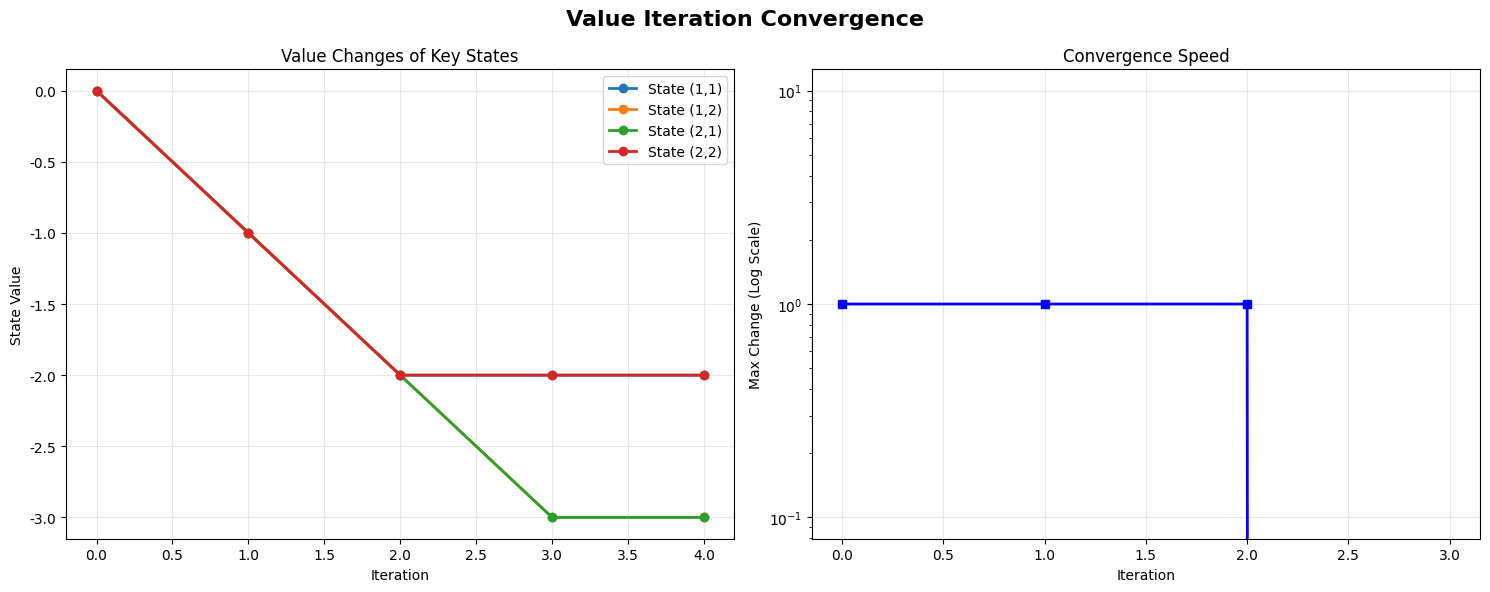

In [14]:
# 가치 반복 수렴 과정 시각화
plot_convergence(vi_history, "Value Iteration Convergence")  # 가치 반복의 수렴 과정

### 정책 반복 vs 가치 반복 비교
1. 최적 가치 함수 비교: 정책 반복과 가치 반복이 동일한 결과를 도출하는지 확인

In [15]:
value_diff = np.abs(optimal_V - vi_V)
max_diff = np.max(value_diff)
print(f"최대 차이: {max_diff:.8f}")

if max_diff < 1e-6:
    print("✓ 두 방법 모두 동일한 최적 가치 함수 도출")
else:
    print("✗ 차이 발생 (수렴 기준 조정 필요)")

최대 차이: 0.00000000
✓ 두 방법 모두 동일한 최적 가치 함수 도출


2. 최적 정책 비교:

In [16]:
policy_diff = np.sum(np.abs(optimal_policy - vi_policy))
print(f"정책 차이 합계: {policy_diff:.0f}")

if policy_diff == 0:
    print("✓ 두 방법 모두 동일한 최적 정책 도출")
else:
    print("✗ 정책에 차이 발생")

정책 차이 합계: 0
✓ 두 방법 모두 동일한 최적 정책 도출


3. 수렴 속도 비교:

In [17]:
# 수렴 속도 비교
pi_iterations = len(pi_history['values'])
vi_iterations = len(vi_history) - 1  # 초기값 제외

print(f"정책 반복: {pi_iterations}회 (각 회마다 정책 평가 포함)")
print(f"가치 반복: {vi_iterations}회")

정책 반복: 3회 (각 회마다 정책 평가 포함)
가치 반복: 4회


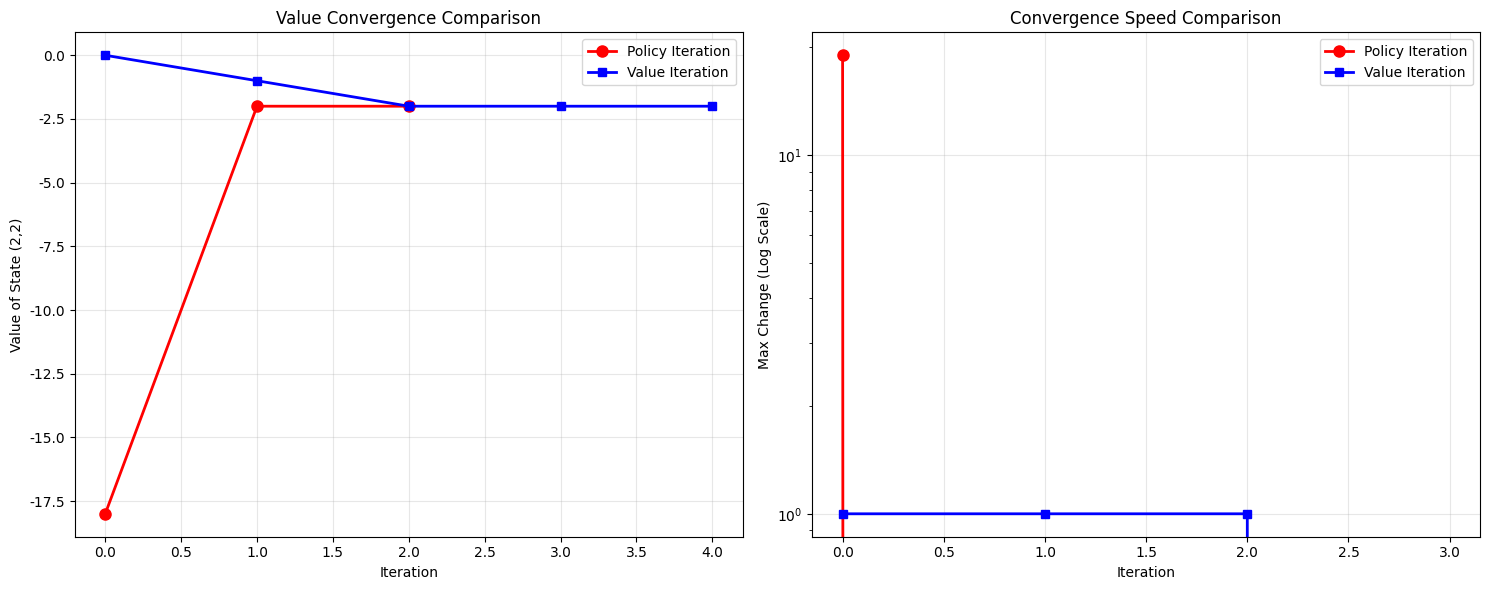

In [18]:
# 수렴 과정 비교 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 주요 상태의 가치 변화 비교
state_to_track = 10  # 중앙 근처 상태
row, col = state_to_coord(state_to_track)

# 정책 반복의 가치 변화
pi_values = [v[state_to_track] for v in pi_history['values']]
ax1.plot(pi_values, 'ro-', linewidth=2, markersize=8, label='Policy Iteration')  # 정책 반복

# 가치 반복의 가치 변화  
vi_values = [v[state_to_track] for v in vi_history]
ax1.plot(vi_values, 'bs-', linewidth=2, markersize=6, label='Value Iteration')  # 가치 반복

ax1.set_xlabel('Iteration')  # 반복 횟수
ax1.set_ylabel(f'Value of State ({row},{col})')  # 상태 ({row},{col})의 가치
ax1.set_title('Value Convergence Comparison')  # 주요 상태의 가치 수렴 비교
ax1.legend()
ax1.grid(True, alpha=0.3)

# 전체 변화량 비교
# 정책 반복: 각 정책 평가의 마지막 변화량 추정
pi_changes = []
for i in range(1, len(pi_history['values'])):
    change = np.max(np.abs(pi_history['values'][i] - pi_history['values'][i-1]))
    pi_changes.append(change)

# 가치 반복: 각 반복의 변화량
vi_changes = []
for i in range(1, len(vi_history)):
    change = np.max(np.abs(vi_history[i] - vi_history[i-1]))
    vi_changes.append(change)

ax2.semilogy(pi_changes, 'ro-', linewidth=2, markersize=8, label='Policy Iteration')  # 정책 반복
ax2.semilogy(vi_changes, 'bs-', linewidth=2, markersize=6, label='Value Iteration')  # 가치 반복

ax2.set_xlabel('Iteration')  # 반복 횟수
ax2.set_ylabel('Max Change (Log Scale)')  # 최대 변화량 (로그 스케일)
ax2.set_title('Convergence Speed Comparison')  # 수렴 속도 비교
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 동적 계획법의 한계와 의의

동적 계획법의 요구사항:
- 환경 모델 완전 지식: P(s'|s,a), R(s,a) 모두 알아야 함<br>
- 마르코프 성질: 현재 상태만으로 미래 예측 가능<br>
- 유한한 상태/행동 공간: 모든 상태를 방문 가능<br>

동적 계획법의 한계:
1. 모델 기반 접근법 → 실제 환경에서는 전이 확률과 보상을 정확히 알기 어려움
2. 차원의 저주 → 상태 공간이 커질수록 계산량이 기하급수적으로 증가
3. 연속 상태/행동 공간 처리 어려움 → 실제 로봇 제어나 연속 제어 문제에 직접 적용 한계

동적 계획법의 의의:
1. 이론적 기반 제공 → 강화학습의 수학적 토대와 최적성 이론
2. 다른 알고리즘의 비교 기준 → Monte Carlo, TD Learning 등의 성능 평가 기준
3. 근사 동적 계획법으로 확장 가능 → Function Approximation, Deep RL의 기초

실제 적용 가능한 문제 예시:<br>
- 격자 세계 (Grid World) 내비게이션<br>
- 간단한 게임 (틱택토, 체스 등)<br>
- 재고 관리 시스템<br>
- 간단한 금융 포트폴리오 최적화<br>
- 작은 규모의 자원 할당 문제<br>

실제 환경에서 필요한 확장:<br>
- 모델-프리 방법: Monte Carlo, TD Learning<br>
- 함수 근사: Neural Networks, Linear Function Approximation<br>
- 샘플링 기반 계획: MCTS (Monte Carlo Tree Search)<br>
- 근사 동적 계획법: ADP (Approximate Dynamic Programming)<br>

## Chapter 4 정리: 동적 계획법

✓ 학습한 핵심 개념:
1. 동적 계획법의 두 가지 원리
   - 중복되는 부분 문제 + 최적 부분 구조
   - 벨만 방정식의 반복적 적용

2. 정책 평가 (Policy Evaluation)
   - 고정된 정책의 성능을 수치적으로 평가
   - 벨만 기대 방정식을 이용한 반복 업데이트

3. 정책 개선 (Policy Improvement)
   - 그리디 정책으로 성능 향상 보장
   - 행동 가치 함수 Q(s,a) 활용

4. 두 가지 주요 알고리즘
   - 정책 반복: 정확하지만 계산량 많음
   - 가치 반복: 효율적이고 구현 간단

✓ 실습 결과:<br>
- GridWorld 4x4 환경에서 최적 정책 도출<br>
- 정책 반복: 3회 반복으로 수렴<br>
- 가치 반복: 4회 반복으로 수렴<br>
- 두 방법 모두 동일한 최적해 도출 확인<br>